In this example we use AdOR method.

# Import Packages

In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, clear_output

np.set_printoptions(precision=5 , suppress=True)

In [2]:
# import AdOR package
from ador import *

## Data

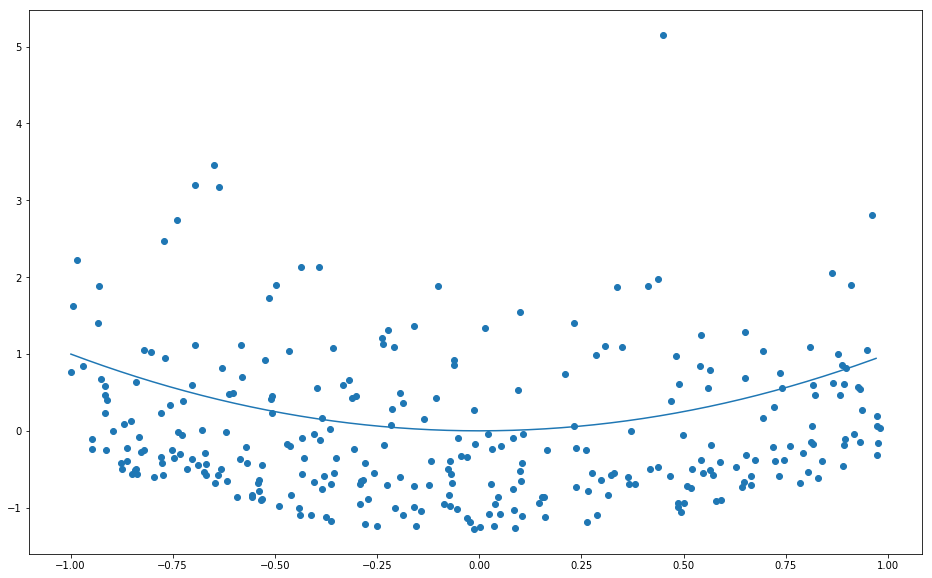

In [3]:
np.random.seed(31)
dimX = 1
n_samples = 300
X = np.random.rand(n_samples, dimX)*2-1
FuncX = X**2
Y_biased = FuncX + np.random.exponential(scale=1., size=(n_samples,1))
Y = Y_biased - np.mean(Y_biased)


Hx = np.arange(np.min(X),np.max(X),0.01)[np.newaxis].T
FuncHX = Hx**2


plt.figure(1, figsize=(16,10))
plt.scatter(X, Y)
plt.plot(Hx, FuncHX)
plt.show()

# Create New Model

In [4]:
# struct new model using ador class
MODEL1 = ador(NumOfRegressors=dimX, BatchSize=128)

In [5]:
# add dense layers (fully_connected) to regression network.
MODEL1.Reg_GetDenseLayer(LayerID='hidden1', LayerSize=6, Activation=tf.nn.tanh,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.Reg_GetDenseLayer(LayerID='hidden2', LayerSize=6, Activation=tf.nn.sigmoid,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.Reg_GetDenseLayer(LayerID='hidden3', LayerSize=6, Activation=tf.nn.leaky_relu,
                        WeightInitializer=tf.contrib.layers.xavier_initializer(),
                        BiasInitializer=tf.contrib.layers.xavier_initializer())
# specify 'out' for last layer. it forces model not to add bias term to this layer.
MODEL1.Reg_GetDenseLayer(LayerID='out', LayerSize=1, Activation=None,
                        WeightInitializer=tf.contrib.layers.xavier_initializer())

In [6]:
# add dense layers (fully_connected) to mutual information network.
MODEL1.MI_GetDenseLayer(LayerID='hidden1', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.MI_GetDenseLayer(LayerID='hidden2', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
MODEL1.MI_GetDenseLayer(LayerID='hidden3', LayerSize=30, Activation=tf.nn.leaky_relu,
                       WeightInitializer=tf.contrib.layers.xavier_initializer(),
                       BiasInitializer=tf.contrib.layers.xavier_initializer())
# specify 'out' for last layer. it forces model not to add bias term to this layer
MODEL1.MI_GetDenseLayer(LayerID='out', LayerSize=1, Activation=None,
                       WeightInitializer=tf.contrib.layers.xavier_initializer())

In [7]:
# when the structure of network is constructed, call 'ConstructGraph' method. it creates the whole computational graph
MODEL1.ConstructGraph()

In [8]:
# specify optimizer for each net
MODEL1.Reg_DefineOptimizer(optimizer=tf.train.AdamOptimizer, beta1=0.9, beta2=0.999)
MODEL1.MI_DefineOptimizer(optimizer=tf.train.AdamOptimizer, beta1=0.9, beta2=0.999)

In [9]:
# you can create tensorboard summary. list of scalers and histograms can be changed by 'Options' input
MODEL1.TensorboardSummaryCreator(directory="summaries\\Test01")

# Train the Model

In [20]:
# hyper-parameters

# learn rates
RLearnRate = 0.0005
MILearnRate = 0.0005

# number of updating steps at each iteration
nReg_Steps = 20
nMI_Steps = 20

# number of whole iterations
MaxIters = 500

In [21]:
# starting a new tensorflow session

# configurations
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # making sure Tensorflow doesn't overflow the GPU

# call 'GetSession' method to create a new session
MODEL1.GetSession(config=config)

iteration: 0     Estimated Entropy of Residual:  1.0975178950764164


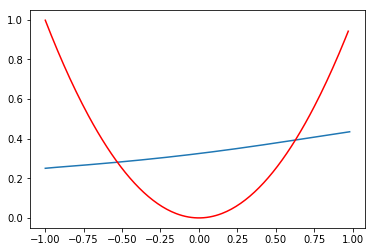

iteration: 20     Estimated Entropy of Residual:  1.0906808780849033


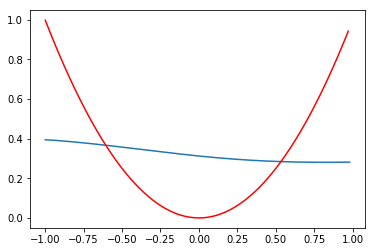

iteration: 40     Estimated Entropy of Residual:  1.0719658621170947


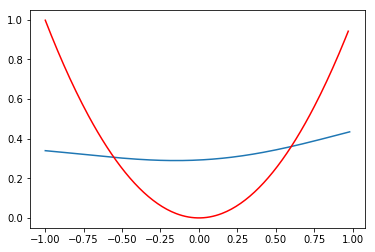

iteration: 60     Estimated Entropy of Residual:  1.0382231912248132


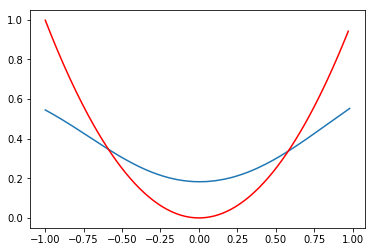

iteration: 80     Estimated Entropy of Residual:  0.9715599030087541


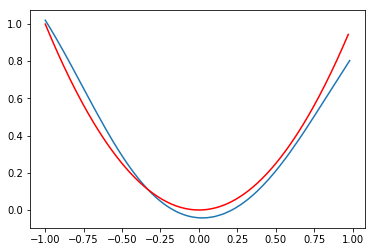

iteration: 100     Estimated Entropy of Residual:  0.9375966519008876


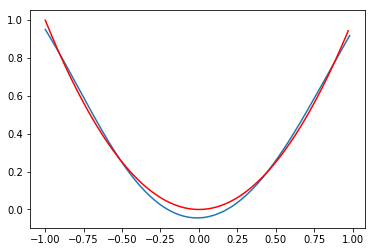

iteration: 120     Estimated Entropy of Residual:  0.9177272081248868


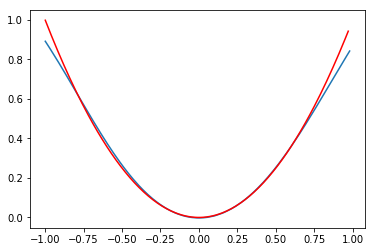

iteration: 140     Estimated Entropy of Residual:  0.9374377728070629


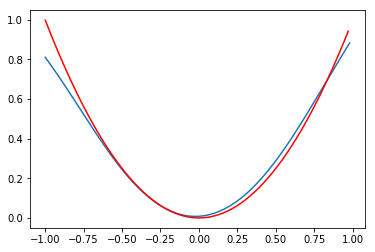

iteration: 160     Estimated Entropy of Residual:  0.928614704233504


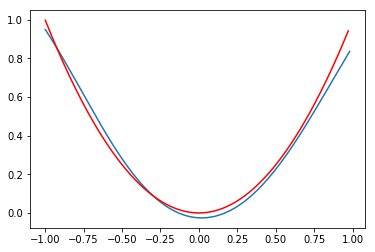

iteration: 180     Estimated Entropy of Residual:  0.9521589976567557


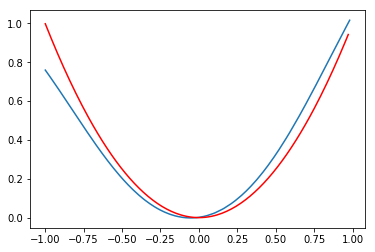

iteration: 200     Estimated Entropy of Residual:  0.9339550898411901


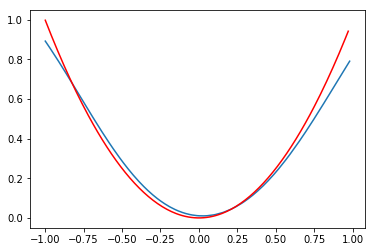

iteration: 220     Estimated Entropy of Residual:  0.9243265221262775


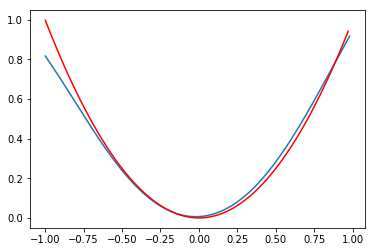

iteration: 240     Estimated Entropy of Residual:  0.9263133249160402


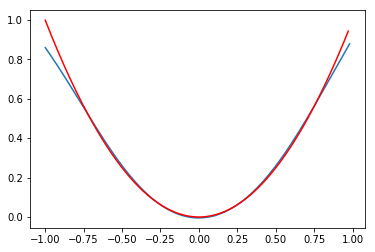

iteration: 260     Estimated Entropy of Residual:  0.9325589880301224


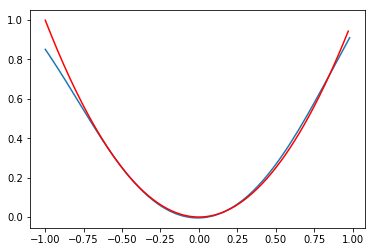

iteration: 280     Estimated Entropy of Residual:  0.9595582671105856


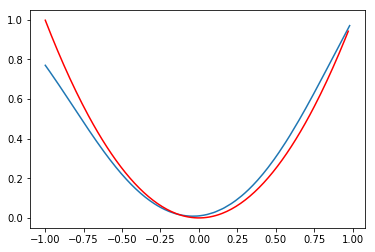

iteration: 300     Estimated Entropy of Residual:  0.9215433683424084


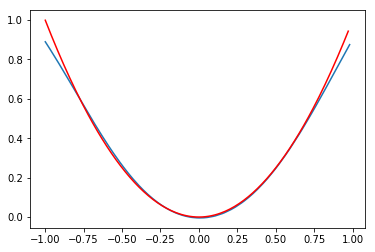

iteration: 320     Estimated Entropy of Residual:  0.9322532535707317


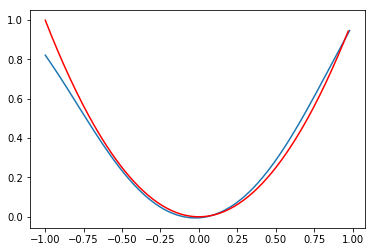

iteration: 340     Estimated Entropy of Residual:  0.9437564959158204


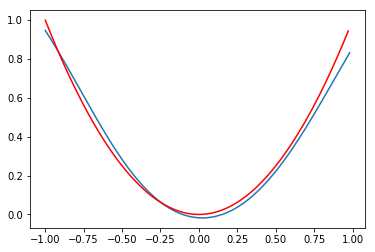

iteration: 360     Estimated Entropy of Residual:  0.980425282934779


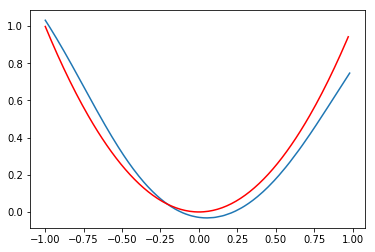

iteration: 380     Estimated Entropy of Residual:  0.9879122845950428


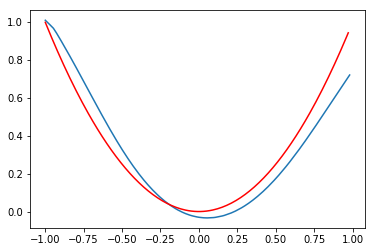

iteration: 400     Estimated Entropy of Residual:  0.928044847039422


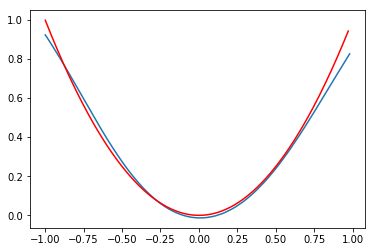

iteration: 420     Estimated Entropy of Residual:  0.9758457075381144


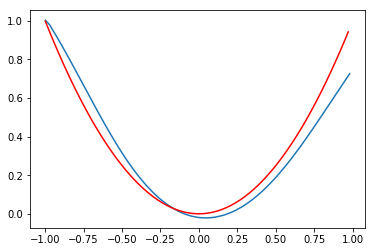

iteration: 440     Estimated Entropy of Residual:  0.9344254317228322


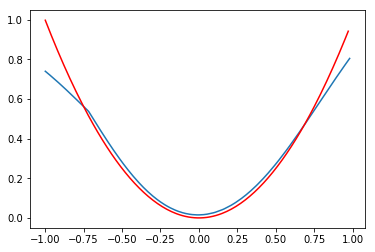

iteration: 460     Estimated Entropy of Residual:  0.9521648917921


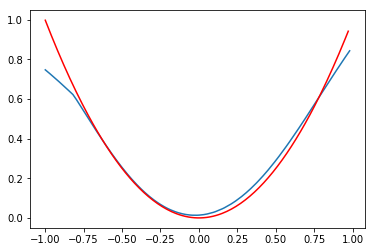

iteration: 480     Estimated Entropy of Residual:  0.9409212948539527


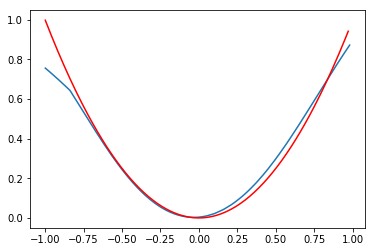

In [22]:
EnsemblePredicts = list()
EnsemblePredictsHx = list()

# iteration
for iters in range(MaxIters):
    
    # use 'UpdateRegNet' method to update regression network by back-propagattion
    AllPredicts, _, _, _, _, Res_Entr = MODEL1.UpdateRegNet(X=X, Y=Y, iteration=iters, 
                                                            RegLearnRate=RLearnRate, nReg_Steps=nReg_Steps)
    
    # use 'UpdateMINet' method to update mutual-information network by back-propagattion
    _ = MODEL1.UpdateMINet(X=X, Y=Y, iteration=iters, 
                           MILearnRate=MILearnRate, nMI_Steps=nMI_Steps)
    
    # use 'TestModel' method to validate the obtained regression-net
    MSE_iter, _ = MODEL1.TestModel(X=X, Y=Y, iteration=iters)
    
    
    # verbose at each 50 iteration
    if iters%20 == 0:
        print('iteration:', iters , '    Estimated Entropy of Residual: ', Res_Entr)
        
        if iters>=200:
            EnsemblePredicts.append(AllPredicts-np.mean(AllPredicts))
            AllPredictsHx = MODEL1.PredictAfterTrain(X=Hx)
            EnsemblePredictsHx.append(AllPredictsHx-np.mean(AllPredictsHx))
        
        Imlists = sorted(zip(*[X, AllPredicts+np.mean(FuncHX)-np.mean(AllPredicts)]))
        new_x, new_y = list(zip(*Imlists))
        
        plt.figure()
        plt.plot(new_x, new_y)
        plt.plot(Hx, FuncHX, 'r')
        plt.show()
    
# use 'PredictAfterTrain' method to get predictions (outputs of regression)
AllPredictsAfterTrain = MODEL1.PredictAfterTrain(X=X)

# ensemble
EnsemblePredictsWhole = np.mean(EnsemblePredicts, axis=0)
Imlists = sorted(zip(*[X, EnsemblePredictsWhole+np.mean(FuncHX)-np.mean(EnsemblePredictsWhole)]))
new_x_AT, new_y_AT = list(zip(*Imlists))

In [32]:
# use 'EndSession' method to close session after training.
# Note that by closing session, the trained model no longer can be used.
MODEL1.EndSession()

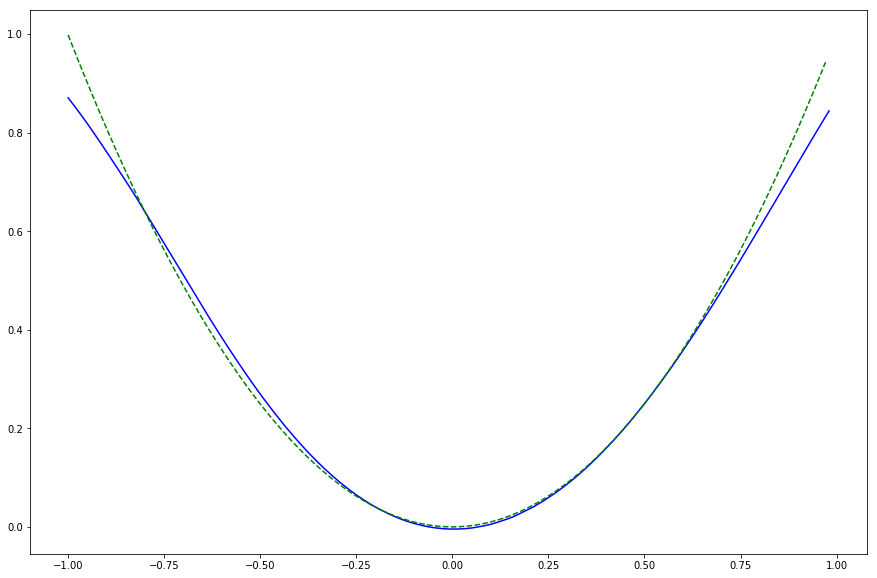

In [34]:
plt.figure(figsize=(15,10))
plt.plot(new_x_AT, new_y_AT, 'b')
plt.plot(Hx, FuncHX, 'g--')
plt.show()